# NSGA-III

In [1]:
from math import factorial
import random

import matplotlib.pyplot as plt
import numpy
import pymop.factory

from deap import algorithms
from deap import base
from deap import benchmarks
from deap.benchmarks.tools import igd
from deap.benchmarks import tools
from deap import creator
from deap import tools

In [2]:


def NSGA3(nobj=3, popsize=None, evaluate=benchmarks.dtlz2, evaluate_args={"obj": 3} , ndim=12, p=12, ngen=400, seed=None):

    H = factorial(nobj + p - 1) / (factorial(p) * factorial(nobj - 1))

    if (popsize is None):
        MU = int(H + (4 - H % 4))
    else:
        MU=popsize
    BOUND_LOW, BOUND_UP = 0.0, 1.0
    CXPB = 1.0
    MUTPB = 1.0
    
    ##
    
    print("Population size=%d dim=%d nobj=%d"%(MU, NDIM, nobj))
    
    # Create uniform reference point
    ref_points = tools.uniform_reference_points(nobj, p)
    print("Reference points: %d (H=%d)"%(len(ref_points), H))
    # Create classes
    if (hasattr(creator, "FitnessMin")):
        # Deleting any previous definition (to avoid warning message)
        del creator.FitnessMin
    creator.create("FitnessMin", base.Fitness, weights=(-1.0,) * nobj)
    
    if (hasattr(creator, "Individual")):
        # Deleting any previous definition (to avoid warning message)
        del creator.Individual
    creator.create("Individual", list, fitness=creator.FitnessMin)
    ##

    pf = tools.ParetoFront()
    
    # Toolbox initialization
    def uniform(low, up, size=None):
        try:
            return [random.uniform(a, b) for a, b in zip(low, up)]
        except TypeError:
            return [random.uniform(a, b) for a, b in zip([low] * size, [up] * size)]

    toolbox = base.Toolbox()
    toolbox.register("attr_float", uniform, BOUND_LOW, BOUND_UP, ndim)
    toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.attr_float)
    toolbox.register("population", tools.initRepeat, list, toolbox.individual)

    
    # Evaluation function to use
    if (evaluate_args is None):
        toolbox.register("evaluate", evaluate)
    else:
        toolbox.register("evaluate", evaluate, **evaluate_args)

        
#
    toolbox.register("mate", tools.cxSimulatedBinaryBounded, low=BOUND_LOW, up=BOUND_UP, eta=30.0)
    toolbox.register("mutate", tools.mutPolynomialBounded, low=BOUND_LOW, up=BOUND_UP, eta=20.0, indpb=1.0/ndim)
    toolbox.register("select", tools.selNSGA3, ref_points=ref_points)
    ##
    random.seed(seed)

    # Initialize statistics object
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("avg", numpy.mean, axis=0)
    stats.register("std", numpy.std, axis=0)
    stats.register("min", numpy.min, axis=0)
    stats.register("max", numpy.max, axis=0)

    nbeval=0
    
    logbook = tools.Logbook()
    logbook.header = "gen", "evals", "std", "min", "avg", "max"

    pop = toolbox.population(n=MU)

    # Evaluate the individuals with an invalid fitness
    invalid_ind = [ind for ind in pop if not ind.fitness.valid]
    fitnesses = toolbox.map(toolbox.evaluate, invalid_ind)
    nbeval+=len(invalid_ind)
    for ind, fit in zip(invalid_ind, fitnesses):
        ind.fitness.values = fit

    # Compile statistics about the population
    record = stats.compile(pop)
    logbook.record(gen=0, evals=len(invalid_ind), **record)
    #print(logbook.stream)

    pf.update(pop)
    
    # Begin the generational process
    for gen in range(1, NGEN):
        if (gen%100==0):
            print("%d"%(gen),end="", flush=True)
        elif (gen%10==0):
            print("+",end="", flush=True)
        else:
            print(".",end="", flush=True)

        offspring = algorithms.varAnd(pop, toolbox, CXPB, MUTPB)

        #print("--0--")
        # Evaluate the individuals with an invalid fitness
        invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
        fitnesses = toolbox.map(toolbox.evaluate, invalid_ind)
        nbeval+=len(invalid_ind)
        for ind, fit in zip(invalid_ind, fitnesses):
            ind.fitness.values = fit
        #print("--1--")
        # Select the next generation population from parents and offspring
        pop = toolbox.select(pop + offspring, MU)
        #print("--2--")

        # Compile statistics about the new population
        record = stats.compile(pop)
        logbook.record(gen=gen, evals=len(invalid_ind), **record)
        #print(logbook.stream)
        pf.update(pop)
        #print("--3--")
        
    print("Nb eval: %d"%(nbeval))
    return pop, pf, logbook

Population size=92 dim=12 nobj=3
Reference points: 91 (H=91)
.........+.........+.........+.........+.........+.........+.........+.........+.........+.........100.........+.........+.........+.........+.........+.........+.........+.........+.........+.........200.........+.........+.........+.........+.........+.........+.........+.........+.........+.........300.........+.........+.........+.........+.........+.........+.........+.........+.........+.........Nb eval: 36800
0.0014110245458832096


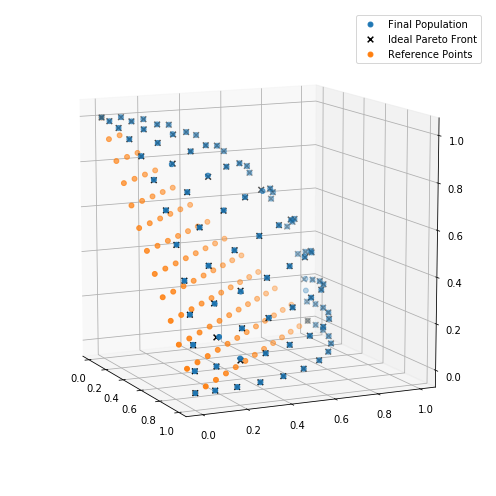

In [17]:
#nobj=3, evaluation=benchmarks.dtlz2, ndim=12, p=12, ngen=400, seed=None):

NOBJ=3
EVAL=benchmarks.dtlz2
PROBLEM=EVAL.__name__
NDIM=12
P=12
NGEN=400

pop, pf, stats = NSGA3(nobj=NOBJ, evaluate=EVAL, ndim=NDIM, p=P, ngen=NGEN)
pop_fit = numpy.array([ind.fitness.values for ind in pop])

ref_points = tools.uniform_reference_points(NOBJ, P)

problem = pymop.factory.get_problem(PROBLEM, n_var=NDIM, n_obj=NOBJ)
if (problem is not None):
    pf = problem.pareto_front(ref_points)
    print(igd(pop_fit, pf))

import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d as Axes3d

fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111, projection="3d")

p = numpy.array([ind.fitness.values for ind in pop])
ax.scatter(p[:, 0], p[:, 1], p[:, 2], marker="o", s=24, label="Final Population")

if (problem is not None):
    ax.scatter(pf[:, 0], pf[:, 1], pf[:, 2], marker="x", c="k", s=32, label="Ideal Pareto Front")


ax.scatter(ref_points[:, 0], ref_points[:, 1], ref_points[:, 2], marker="o", s=24, label="Reference Points")

ax.view_init(elev=11, azim=-25)
ax.autoscale(tight=True)
plt.legend()
plt.tight_layout()
plt.savefig("nsga3.png")
plt.show()

In [ ]:
NOBJ=9
EVAL=benchmarks.dtlz2
PROBLEM=EVAL.__name__
NDIM=12
P=3
NGEN=400



pop, pf, stats = NSGA3(nobj=NOBJ, popsize=100, evaluate=EVAL, evaluate_args={"obj": 9}, ndim=NDIM, p=P, ngen=NGEN)

numpy.save("dtlz2_nsga3_pf", pf)

In [3]:
NOBJ=9
EVAL=benchmarks.dtlz2
PROBLEM=EVAL.__name__
NDIM=12
P=6
ref_points = tools.uniform_reference_points(NOBJ, P)

problem = pymop.factory.get_problem(PROBLEM, n_var=NDIM, n_obj=NOBJ)
if (problem is not None):
    pf_ref = problem.pareto_front(ref_points)
pf_nsga3_decision=numpy.load("dtlz2_nsga3_pf.npy")
pf_nsga3=[]
for ind in pf_nsga3_decision:
    pf_nsga3.append(EVAL(ind, obj=NOBJ))
pf_nsga2_decision=numpy.load("dtlz2_nsga2_pf.npy")
pf_nsga2=[]
for ind in pf_nsga2_decision:
    pf_nsga2.append(EVAL(ind, obj=NOBJ))
print("PF size: ref %d, NSGA2 %d, NSGA3 %d"%(len(pf_ref), len(pf_nsga2), len(pf_nsga3)))
print("Size of one element: ref: %d, NSGA2: %d, NSGA3: %d"%(len(pf_ref[0]), len(pf_nsga2[0]), len(pf_nsga3[0])))

PF size: ref 3003, NSGA2 6965, NSGA3 11919
Size of one element: ref: 9, NSGA2: 9, NSGA3: 9


In [ ]:
from deap.tools._hypervolume import hv
#print("Hypervolume: %f"%(hv.hypervolume([np.array([1,0]), np.array([1,1]), np.array([0,1])], np.array([2,2]))))
  
# Compute different metrics to compare the pareto fronts

## hypervolume
print(" == Hypervolume ==")
ref=[1]*NOBJ

## too slow...
#print("Reference: "+str(hv.hypervolume(pf_ref, ref)))
#print("NSGA2: "+str(hv.hypervolume(pf_nsga2, ref)))
#print("NSGA3: "+str(hv.hypervolume(pf_nsga3, ref)))

In [4]:
## IGD
igd_nsga2 = benchmarks.tools.igd(pf_nsga2, pf_ref)
print("IGD NSGA2-ref: %f"%(igd_nsga2))

igd_nsga3 = benchmarks.tools.igd(pf_nsga3, pf_ref)
print("IGD NSGA3-ref: %f"%(igd_nsga3))


IGD NSGA2-ref: 0.533484
IGD NSGA3-ref: 0.230875


In [13]:
pf_nsga2_w=[]
for ind in pf_nsga2:
    indw=[-1*w for w in ind]
    pf_nsga2_w.append(indw)

pf_nsga3_w=[]
for ind in pf_nsga3:
    indw=[-1*w for w in ind]
    pf_nsga3_w.append(indw)


In [16]:
from deap.tools.emo import isDominated
## number of dominated points wrt the ref pf
nb_pts_dom2=0 
nb_pts_dom3=0 



for i, ind2 in enumerate(pf_nsga2_w):
    for j,ind3 in enumerate(pf_nsga3_w):
        if (isDominated(ind2, ind3)):
            nb_pts_dom2+=1
            break
        
print("NSGA2 dominated points: %d (on %d)"%(nb_pts_dom2, len(pf_nsga2_w)))

for i, ind3 in enumerate(pf_nsga3_w):
    for j,ind2 in enumerate(pf_nsga2_w):
        if (isDominated(ind3, ind2)):
            nb_pts_dom3+=1
            break

print("NSGA3 dominated points: %d (on %d)"%(nb_pts_dom3, len(pf_nsga3_w)))


NSGA2 dominated points: 6391 (on 6965)
NSGA3 dominated points: 8 (on 11919)
